<a href="https://colab.research.google.com/github/7pupuwen/PCB_QDETECTION/blob/main/PCB_Detection_9.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
api_token = {"username":"doudoutz","key":"0c5febc722e952ed3a94be3165401d06"}
import json
import zipfile
import os

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

!kaggle datasets download -d norbertelter/pcb-defect-dataset -q
!unzip -q pcb-defect-dataset.zip -d pcb_data

Dataset URL: https://www.kaggle.com/datasets/norbertelter/pcb-defect-dataset
License(s): unknown


In [3]:
#export KAGGLE_USERNAME=doudoutz
# export KAGGLE_KEY=0c5febc722e952ed3a94be3165401d06

In [4]:
! pip install pennylane -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 53.5 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd

# Set the label files
train_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/train/labels"
val_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/val/labels"
test_labels_path = "/kaggle/pcb_data/pcb-defect-dataset/test/labels"

# Definition of convert label to csv
def convert_labels_to_csv(labels_path, output_csv):
    data = []

    # read every .txt file
    for file in os.listdir(labels_path):
        if file.endswith(".txt"):
            file_path = os.path.join(labels_path, file)
            image_name = file.replace(".txt", ".jpg")  # The file name corresponding to the image
            with open(file_path, "r") as f:
                lines = f.readlines()  #A .txt may have multiple lines of tags

                for line in lines:
                    values = line.strip().split()
                    class_id = int(values[0])  # Defect category
                    x_center, y_center, width, height = map(float, values[1:])  # Analyze numerical values

                    # Save to DataFrame
                    data.append([image_name, class_id, x_center, y_center, width, height])

    # create DataFrame
    df = pd.DataFrame(data, columns=["image_name", "class_id", "x_center", "y_center", "width", "height"])

    # Save as CSV
    df.to_csv(output_csv, index=False)

    print(f"{output_csv} convert finish！")
    print(df.head(10))  # show the first 10 data

# covert `train`、`val`、`test` labels
convert_labels_to_csv(train_labels_path, "train_labels.csv")
convert_labels_to_csv(val_labels_path, "val_labels.csv")
convert_labels_to_csv(test_labels_path, "test_labels.csv")

train_labels.csv convert finish！
                                       image_name  class_id  x_center  \
0    rotation_90_light_09_mouse_bite_05_2_600.jpg         0    0.0300   
1         rotation_270_light_09_spur_08_5_600.jpg         1    0.6065   
2         rotation_270_light_09_spur_08_5_600.jpg         1    0.6448   
3         rotation_270_light_09_spur_08_5_600.jpg         1    0.4468   
4              light_04_open_circuit_13_2_256.jpg         4    0.3858   
5   rotation_270_light_09_mouse_bite_07_1_600.jpg         0    0.6373   
6   rotation_270_light_09_mouse_bite_07_1_600.jpg         0    0.3536   
7   rotation_270_light_09_mouse_bite_07_1_600.jpg         0    0.2795   
8  rotation_90_light_05_open_circuit_07_2_600.jpg         4    0.1925   
9                    l_light_09_spur_09_4_600.jpg         1    0.2800   

   y_center   width  height  
0    0.6867  0.0567  0.0300  
1    0.5449  0.0383  0.0616  
2    0.3719  0.0449  0.0582  
3    0.1098  0.0516  0.0366  
4    0.3358  

In [6]:
import os
import cv2
import numpy as np
import pandas as pd

#Set up image folder
train_images_path = "/kaggle/pcb_data/pcb-defect-dataset/train/images"
val_images_path = "/kaggle/pcb_data/pcb-defect-dataset/val/images"
test_images_path = "/kaggle/pcb_data/pcb-defect-dataset/test/images"

# Read tag CSV
train_labels_csv = "train_labels.csv"
val_labels_csv = "val_labels.csv"
test_labels_csv = "test_labels.csv"

def load_images_and_labels(images_path, labels_csv):
    df = pd.read_csv(labels_csv)  # 讀取 CSV 標籤

    # 合併相同 image_name，取出最常出現的 class_id（單一標籤）
    df = df.groupby("image_name")["class_id"].agg(lambda x: x.value_counts().index[0]).reset_index()

    X, y = [], []

    for _, row in df.iterrows():
        img_path = os.path.join(images_path, row["image_name"])

        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   # 灰階
            img = cv2.resize(img, (64, 64)) / 255.0             # Resize + normalize
            X.append(img)
            y.append(row["class_id"])  # 注意這裡只剩下唯一 class_id

    # 轉成 NumPy
    X = np.array(X)
    y = np.array(y)

    print(f"{labels_csv} processed, image data size: {X.shape}, label data size: {y.shape}")
    return X, y

# read `train`、`val`、`test` data
X_train, y_train = load_images_and_labels(train_images_path, train_labels_csv)
X_val, y_val = load_images_and_labels(val_images_path, val_labels_csv)
X_test, y_test = load_images_and_labels(test_images_path, test_labels_csv)

train_labels.csv processed, image data size: (6370, 64, 64), label data size: (6370,)
val_labels.csv processed, image data size: (802, 64, 64), label data size: (802,)
test_labels.csv processed, image data size: (829, 64, 64), label data size: (829,)


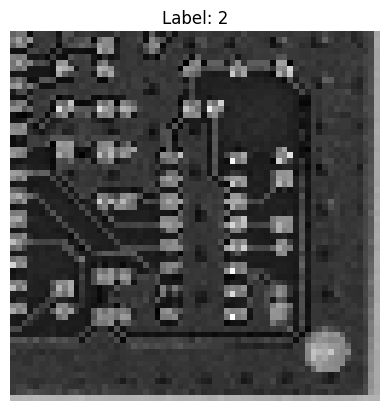

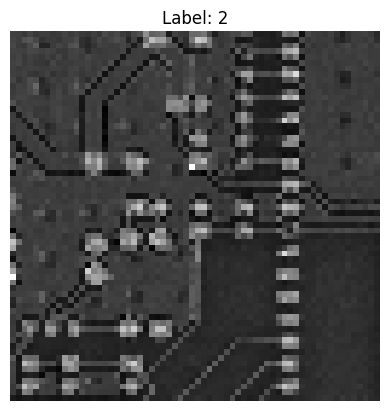

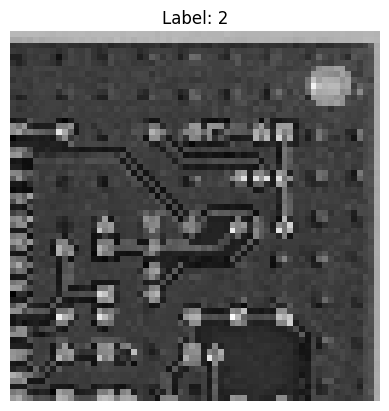

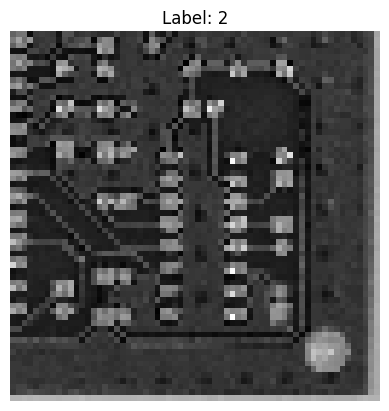

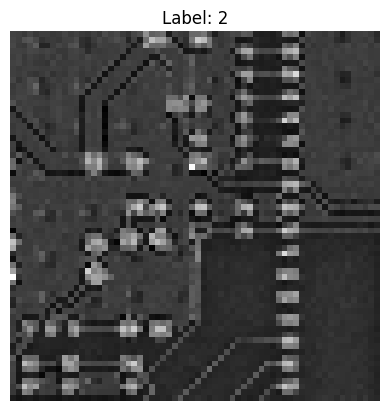

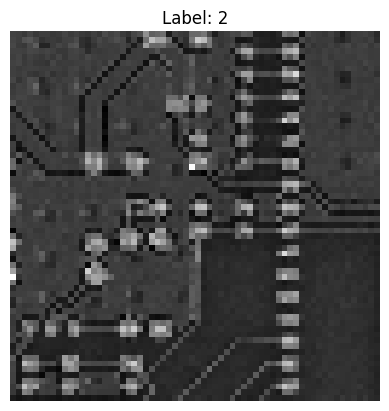

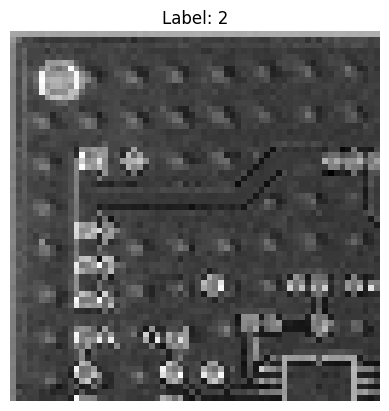

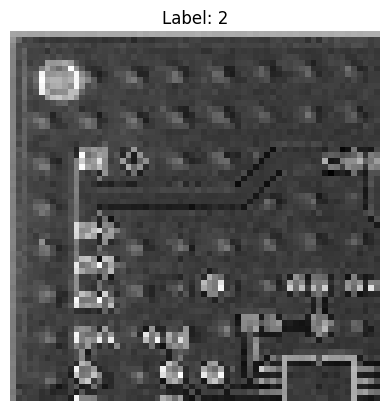

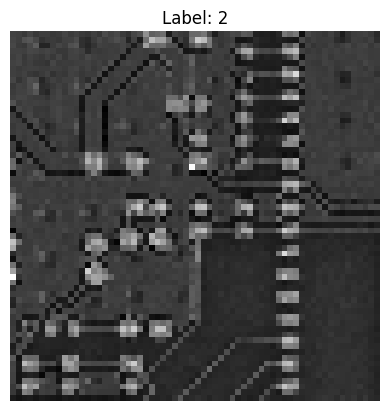

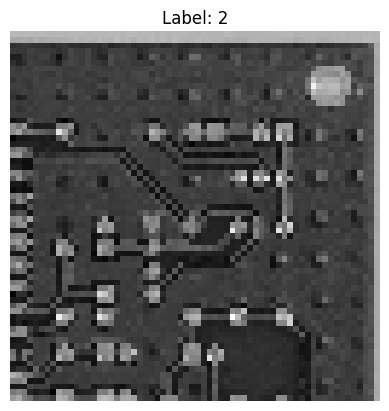

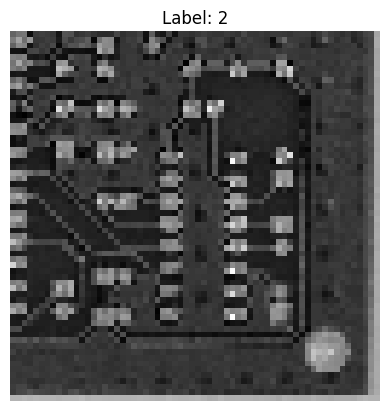

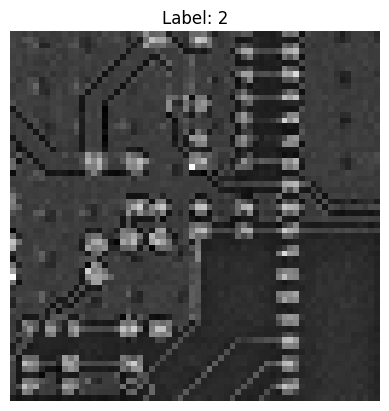

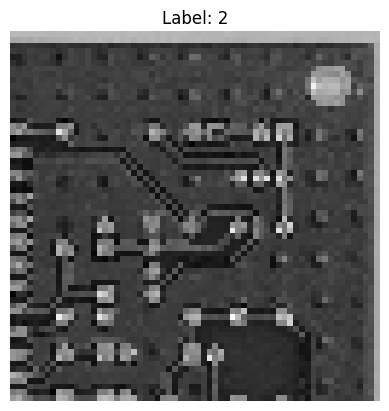

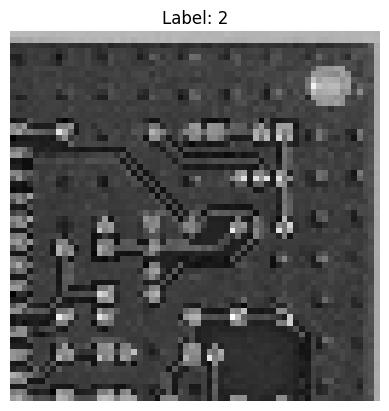

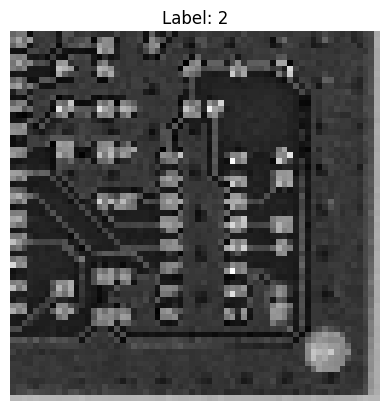

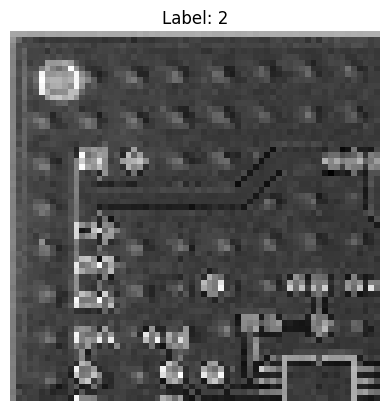

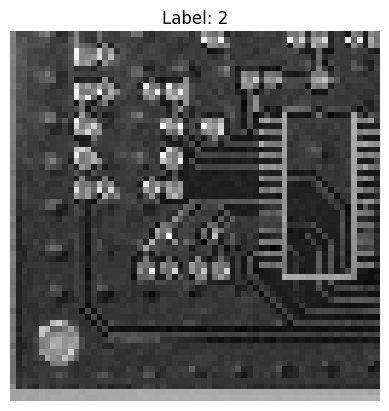

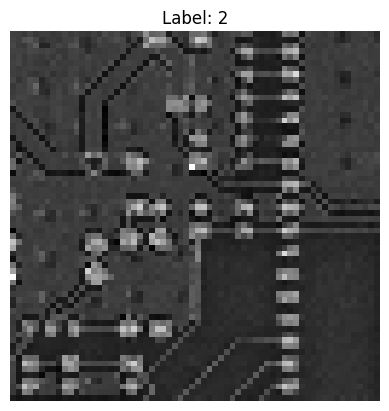

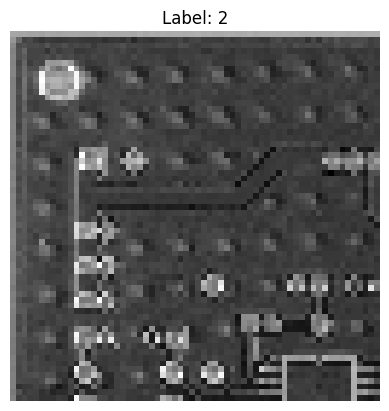

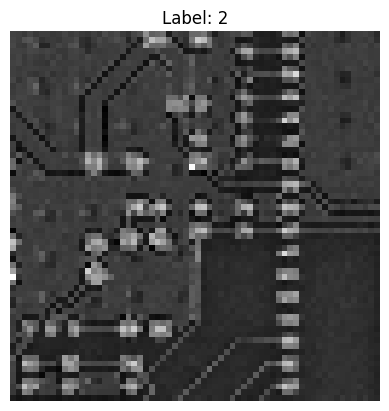

In [11]:
import matplotlib.pyplot as plt

target_label = 2
indices = np.where(y_train == target_label)[0]  # 找出標籤為 3 的索引

# 顯示前 5 張
for i in indices[:20]:
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualize_qcnn(image, quanvolution_func, patch_size=(2,2), feature_dim=8):
    """
    視覺化一張影像在 Quantum Convolution 前後的特徵變化。

    參數：
    - image: 原始影像（2D array，例如 4x4）
    - quanvolution_func: 你定義好的量子卷積函式（例如 quanvolution）
    - patch_size: patch 大小（預設 2x2）
    - feature_dim: 每個 patch 輸出幾維特徵（預設 8 維）
    """
    print("🎯 原始影像 shape:", image.shape)

    # 原始影像視覺化
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap='gray')
    plt.title("原始影像")
    plt.axis('off')
    plt.colorbar()
    plt.show()

    # 應用 QCNN
    q_features = quanvolution_func(image)
    print("🔍 QCNN 特徵 shape:", q_features.shape)

    # 轉換為 patches 結構
    patch_h = image.shape[0] // patch_size[0]
    patch_w = image.shape[1] // patch_size[1]
    q_patches = q_features.reshape(patch_h, patch_w, feature_dim)

    # 顯示每個 patch 的特徵向量
    print("\n📊 每個 Patch 的 8 維特徵：")
    for i in range(patch_h):
        for j in range(patch_w):
            print(f"Patch ({i}, {j}) 特徵:\n", q_patches[i, j])

    # 顯示某一維的特徵分布圖（可切換 k）
    for k in range(feature_dim):
        feature_map_k = q_patches[:, :, k]
        plt.imshow(feature_map_k, cmap='viridis')
        plt.title(f"第 {k} 維量子特徵分布")
        plt.colorbar()
        plt.show()

In [ ]:
i = 0  # 可以改成你想看的那一張
image = X_train[i]  # 一張 2D 影像（例如 4x4）

visualize_qcnn(image, quanvolution_func=quanvolution)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# take 500 data
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=1500, random_state=42, stratify=y_train)
X_val, _, y_val, _ = train_test_split(X_val, y_val, train_size=1000, random_state=42, stratify=y_val)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=1000, random_state=42, stratify=y_test)

# Confirm data shape
print("取樣後的影像數據 (Train):", X_train.shape)  # (500, 64, 64)
print("取樣後的標籤數據 (Train):", y_train.shape)  # (500,)

print("取樣後的影像數據 (Val):", X_val.shape)  # (500, 64, 64)
print("取樣後的標籤數據 (Val):", y_val.shape)  # (500,)

print("取樣後的影像數據 (Test):", X_test.shape)  # (500, 64, 64)
print("取樣後的標籤數據 (Test):", y_test.shape)  # (500,)


取樣後的影像數據 (Train): (1500, 64, 64)
取樣後的標籤數據 (Train): (1500,)
取樣後的影像數據 (Val): (1000, 64, 64)
取樣後的標籤數據 (Val): (1000,)
取樣後的影像數據 (Test): (1000, 64, 64)
取樣後的標籤數據 (Test): (1000,)


(<Figure size 800x500 with 1 Axes>, <Axes: >)

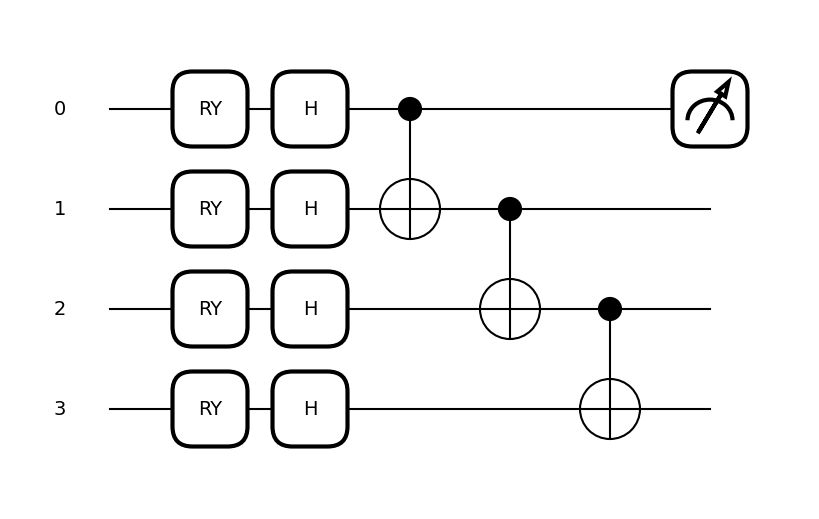

In [ ]:
import pennylane as qml

# Set up the quantum computer simulator (4 qubits, corresponding to 2x2 patch)
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_kernel(x):
    """
    This is a quantum circuit that converts image patches into quantum features
    """
    for i in range(n_qubits):
        qml.RY(x[i] * np.pi, wires=i)  # Embedding image data using Ry gates
        qml.Hadamard(wires=i)  # Join Hadamard Gate

    # oin Quantum Entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])

    return qml.expval(qml.PauliZ(0))  # Output quantum features

x_test = np.random.rand(4)  # 產生 4 個隨機數
qml.draw_mpl(quantum_kernel)(x_test)

In [ ]:
def quanvolution(image):
    output_size = (image.shape[0] //2, image.shape[1] //2)
    q_image = np.zeros(output_size)

    for i in range(0, image.shape[0], 2):
        for j in range(0, image.shape[1], 2):
          patch = image[i:i+2, j:j+2].flatten()
          q_image[i//2, j//2] = quantum_kernel(patch)

    return q_image.flatten()

In [ ]:
# Do Quanvolution to data
# X_train_quanv = np.array([quanvolution(img) for img in X_train])
# X_val_quanv = np.array([quanvolution(img) for img in X_val])
# X_test_quanv = np.array([quanvolution(img) for img in X_test])

# print("Quantum feature size（Train）:", X_train_quanv.shape)
# print("Quantum feature size（Val）:", X_val_quanv.shape)
# print("Quantum feature size（Test）:", X_test_quanv.shape)


In [ ]:
# import numpy as np

# def compute_kernel_matrix(X):
#     """
#     Compute Quantum Kernel Matrix
#     - X: quantum eigenvector (N, d), where N is the number of samples and d is the number of features
#     - returns the Kernel matrix of (N, N)
#     """
#     N = len(X)
#     kernel_matrix = np.zeros((N, N))

#     for i in range(N):
#         for j in range(i, N):  # 只計算上三角矩陣（因為對稱）
#             kernel_matrix[i, j] = np.dot(X[i], X[j])  # 內積當作 Kernel
#             kernel_matrix[j, i] = kernel_matrix[i, j]  # 利用對稱性

#     return kernel_matrix

In [ ]:
#rbf kernel

# def compute_kernel_matrix(X, gamma=0.5):
#     N = len(X)
#     kernel_matrix = np.zeros((N, N))

#     for i in range(N):
#         for j in range(i, N):
#             dist = np.linalg.norm(X[i] - X[j]) ** 2
#             kernel_matrix[i, j] = np.exp(-gamma * dist)  # Gaussian Kernel
#             kernel_matrix[j, i] = kernel_matrix[i, j]

#     return kernel_matrix

In [ ]:
# Quantum Kernel Matrix
# train_kernel_matrix = compute_kernel_matrix(X_train_quanv)
# val_kernel_matrix = np.array([[np.dot(x1, x2) for x2 in X_train_quanv] for x1 in X_val_quanv])
# test_kernel_matrix = np.array([[np.dot(x1, x2) for x2 in X_train_quanv] for x1 in X_test_quanv])

# print("Train Kernel Matrix:", train_kernel_matrix.shape)  # (N_train, N_train)
# print("Val Kernel Matrix:", val_kernel_matrix.shape)      # (N_val, N_train)
# print("Test Kernel Matrix:", test_kernel_matrix.shape)    # (N_test, N_train)

In [ ]:
# from sklearn import svm
# from sklearn.metrics import accuracy_score

# # train Quantum SVM
# qsvm = svm.SVC(kernel="precomputed")
# qsvm.fit(train_kernel_matrix, y_train)


In [ ]:
# # test  QSVM in val set
# preds_val = qsvm.predict(val_kernel_matrix)
# accuracy_val = accuracy_score(y_val, preds_val)
# print(f"QSVM Validation Accuracy: {accuracy_val:.4f}")

# # test QSVM in test set
# preds_test = qsvm.predict(test_kernel_matrix)
# accuracy_test = accuracy_score(y_test, preds_test)
# print(f"QSVM Test Accuracy: {accuracy_test:.4f}")


In [ ]:
# Choose label=0&1
X_train_0 = X_train[y_train == 0]
y_train_0 = y_train[y_train == 0]

X_train_1 = X_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

X_val_0 = X_val[y_val == 0]
y_val_0 = y_val[y_val == 0]

X_val_1 = X_val[y_val == 1]
y_val_1 = y_val[y_val == 1]

X_test_0 = X_test[y_test == 0]
y_test_0 = y_test[y_test == 0]

X_test_1 = X_test[y_test == 1]
y_test_1 = y_test[y_test == 1]

print(f"label=0 訓練數據數量: {X_train_0.shape}")
print(f"label=0 訓練數據數量: {X_val_0.shape}")
print(f"label=0 訓練數據數量: {X_test_0.shape}")

print(f"訓練資料 label=1 數量: {X_train_1.shape}")
print(f"驗證資料 label=1 數量: {X_val_1.shape}")
print(f"測試資料 label=1 數量: {X_test_1.shape}")


label=0 訓練數據數量: (256, 64, 64)
label=0 訓練數據數量: (176, 64, 64)
label=0 訓練數據數量: (158, 64, 64)
訓練資料 label=1 數量: (252, 64, 64)
驗證資料 label=1 數量: (164, 64, 64)
測試資料 label=1 數量: (168, 64, 64)


In [ ]:
X_train_0 = np.array([quanvolution(img) for img in X_train_0])
X_val_0 = np.array([quanvolution(img) for img in X_val_0])
X_test_0 = np.array([quanvolution(img) for img in X_test_0])

print(" X_train_0 shape:", X_train_0.shape)  # (84, 特徵數)
print(" X_val_0 shape:", X_val_0.shape)      # (88, 特徵數)
print("X_test_0 shape:", X_test_0.shape)    # (79, 特徵數)

 X_train_0 shape: (256, 1024)
 X_val_0 shape: (176, 1024)
X_test_0 shape: (158, 1024)


In [ ]:
X_train_1 = np.array([quanvolution(img) for img in X_train_1])
X_val_1 = np.array([quanvolution(img) for img in X_val_1])
X_test_1 = np.array([quanvolution(img) for img in X_test_1])

print(" X_train_1 shape:", X_train_1.shape)  # (84, 特徵數)
print(" X_val_1 shape:", X_val_1.shape)      # (82, 特徵數)
print("X_test_1 shape:", X_test_1.shape)    # (84, 特徵數)

 X_train_1 shape: (252, 1024)
 X_val_1 shape: (164, 1024)
X_test_1 shape: (168, 1024)


In [ ]:
# 合併 label=0 和 label=1 的量子特徵數據
X_train_01 = np.vstack([X_train_0, X_train_1])
y_train_01 = np.hstack([y_train_0, y_train_1])

print(f"合併後的訓練數據: {X_train_01.shape}")
print(f"合併後的標籤數據: {y_train_01.shape}")

X_val_01 = np.vstack([X_val_0, X_val_1])
y_val_01 = np.hstack([y_val_0, y_val_1])

print(f"合併後的訓練數據: {X_val_01.shape}")
print(f"合併後的標籤數據: {y_val_01.shape}")

X_test_01 = np.vstack([X_test_0, X_test_1])
y_test_01 = np.hstack([y_test_0, y_test_1])

print(f"合併後的訓練數據: {X_test_01.shape}")
print(f"合併後的標籤數據: {y_test_01.shape}")

合併後的訓練數據: (508, 1024)
合併後的標籤數據: (508,)
合併後的訓練數據: (340, 1024)
合併後的標籤數據: (340,)
合併後的訓練數據: (326, 1024)
合併後的標籤數據: (326,)


In [ ]:
from sklearn.decomposition import PCA
# 先把影像攤平成 2D 數據 (N, 4096)
X_train_flat = X_train_01.reshape(X_train_01.shape[0], -1)
X_val_flat = X_val_01.reshape(X_val_01.shape[0], -1)
X_test_flat = X_test_01.reshape(X_test_01.shape[0], -1)

# 使用 PCA 降維
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.fit_transform(X_val_flat)
X_test_pca = pca.fit_transform(X_test_flat)

print("降維後的數據形狀：", X_train_pca.shape)  # (N, 4)
print("降維後的數據形狀：", X_val_pca.shape)  # (N, 4)


降維後的數據形狀： (508, 16)
降維後的數據形狀： (340, 16)


In [ ]:
# import pennylane as qml
# import pennylane.numpy as np

# n_qubits = 4
# dev = qml.device("default.qubit", wires=n_qubits)

# @qml.qnode(dev)
# def feature_map(x):
#     # 將輸入 x（維度 4 的向量）嵌入到量子態中
#     qml.AngleEmbedding(x, wires=range(n_qubits))
#     # 回傳每個 qubit 上 Pauli-Z 的期望值，形成一個 4 維向量
#     return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


In [ ]:
# def quantum_kernel_fidelity(x1, x2):
#     phi1 = np.array(feature_map(x1))
#     phi2 = np.array(feature_map(x2))
#     # 使用內積的平方作為核值
#     return np.dot(phi1, phi2)**2

In [ ]:
# def compute_quantum_kernel_matrix(X, kernel_func=quantum_kernel_fidelity):
#     N = len(X)
#     K = np.zeros((N, N))
#     for i in range(N):
#         for j in range(i, N):
#             K[i, j] = kernel_func(X[i], X[j])
#             K[j, i] = K[i, j]
#     return K

In [ ]:
import pennylane as qml
import pennylane.numpy as np  # PennyLane 版本的 numpy
import numpy as onp          # 傳統 NumPy，避免混淆時可用 "onp"

n_qubits = 16
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def feature_map(x):
    """
    將輸入 x (長度 <= n_qubits) 嵌入到量子態中，
    回傳每個 qubit 上 PauliZ 的期望值，形成一個長度 = n_qubits 的向量。
    """
    qml.AngleEmbedding(x, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def quantum_kernel_fidelity(x1, x2):
    """
    量子核函數：先透過 feature_map() 得到兩個量子特徵向量 phi1, phi2，
    然後取內積 (dot) 再平方，作為「類似保真度」的核值。
    """

    #使用內稽平方作為核值
    phi1 = np.array(feature_map(x1))
    phi2 = np.array(feature_map(x2))
    return np.dot(phi1, phi2) ** 2


def compute_quantum_kernel_matrix(X1, X2, kernel_func=quantum_kernel_fidelity):
    N1 = len(X1)
    N2 = len(X2)
    K = onp.zeros((N1, N2))
    for i in range(N1):
        for j in range(N2):
            # 這裡要呼叫 kernel_func(X1[i], X2[j]) 兩個參數
            K[i, j] = kernel_func(X1[i], X2[j])
    return K

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# 假設 X_train.shape = (N_train, d)，y_train.shape = (N_train,)
K_train= compute_quantum_kernel_matrix(X_train_pca, X_train_pca, quantum_kernel_fidelity)
K_val= compute_quantum_kernel_matrix(X_val_pca, X_train_pca, quantum_kernel_fidelity)
K_test= compute_quantum_kernel_matrix(X_test_pca, X_train_pca, quantum_kernel_fidelity)

print(f"Train Kernel Matrix: {K_train.shape}")
print(f"Val Kernel Matrix: {K_val.shape}")
print(f"Test Kernel Matrix: {K_test.shape}")

In [ ]:
# 使用 precomputed kernel 的 SVM
qsvm = svm.SVC(kernel="precomputed")
qsvm.fit(K_train, y_train_01)

# 驗證
val_preds = qsvm.predict(K_val)
val_acc   = accuracy_score(y_val_01, val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")

# 測試
test_preds = qsvm.predict(K_test )
test_acc = accuracy_score(y_test_01, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# K_train = compute_quantum_kernel_matrix(X_train_pca)
# K_val = compute_quantum_kernel_matrix(X_val_pca)
# K_test = compute_quantum_kernel_matrix(X_test_pca)



In [ ]:
# from sklearn import svm
# from sklearn.metrics import accuracy_score

# qsvm = svm.SVC(kernel="precomputed")
# qsvm.fit(K_train, y_train_01)

# val_preds = qsvm.predict(K_val)
# test_preds = qsvm.predict(K_test)

# val_acc = accuracy_score(y_val_01, val_preds)
# test_acc = accuracy_score(y_test_01, test_preds)

# print(f"QSVM Validation Accuracy: {val_acc:.4f}")
# print(f"QSVM Test Accuracy: {test_acc:.4f}")


In [ ]:
print("X_train shape:", X_train_pca.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val_pca.shape)
print("y_val shape:", y_val.shape)


In [ ]:
print("train_kernel_matrix shape:", K_train.shape)
print("val_kernel_matrix shape:", K_val.shape)


In [ ]:
# 計算 Kernel Matrix（只使用 label=1 的數據）
# train_kernel_matrix_01 = compute_kernel_matrix(X_train_01)
# val_kernel_matrix_01 = np.array([[np.dot(x1, x2) for x2 in X_train_01] for x1 in X_val_01])
# test_kernel_matrix_01 = np.array([[np.dot(x1, x2) for x2 in X_train_01] for x1 in X_test_01])

# print(f"Train Kernel Matrix (label=1): {train_kernel_matrix_01.shape}")
# print(f"Val Kernel Matrix (label=1): {val_kernel_matrix_01.shape}")
# print(f"Test Kernel Matrix (label=1): {test_kernel_matrix_01.shape}")

In [ ]:
# from sklearn import svm
# from sklearn.metrics import accuracy_score

# # 訓練 Quantum SVM
# qsvm = svm.SVC(kernel="precomputed")
# qsvm.fit(train_kernel_matrix_01, y_train_01)

# # 測試 QSVM 在驗證集
# preds_val_1 = qsvm.predict(val_kernel_matrix_01)
# accuracy_val_1 = accuracy_score(y_val_01, preds_val_1)
# print(f"QSVM Validation Accuracy (label=01): {accuracy_val_1:.4f}")

# # 測試 QSVM 在測試集
# preds_test_1 = qsvm.predict(test_kernel_matrix_01)
# accuracy_test_1 = accuracy_score(y_test_01, preds_test_1)
# print(f"QSVM Test Accuracy (label=01): {accuracy_test_1:.4f}")

In [ ]:
# 傳統 SVM（使用 RBF 核）
classical_svm = svm.SVC(kernel="linear")
classical_svm.fit(X_train_01, y_train_01)
preds_classical = classical_svm.predict(X_test_01)
val_preds_classical = classical_svm.predict(X_val_01)
acc_classical = accuracy_score(y_test_01, preds_classical)
val_classical = accuracy_score(y_val_01, val_preds_classical)

print(f"Classical SVM Accuracy: {val_classical:.4f}")
print(f"Classical SVM Accuracy: {acc_classical:.4f}")